In [4]:
#from pandas_datareader import data, wb
import pandas as pd
# the line below is the fix for is_list_like lub
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import datetime
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2019, 1, 30)
xio = web.DataReader('XIACF', 'yahoo', start, end)
xio.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-08-21,2.30,2.30,2.30,2.30,8784200,2.30
2018-08-22,3.50,2.27,2.30,2.70,116872,2.70
2018-08-23,3.00,2.20,2.68,2.35,7406506,2.35
2018-08-24,2.60,2.22,2.60,2.22,4898137,2.22
2018-08-27,2.65,2.23,2.30,2.35,105011,2.35
2018-08-28,2.65,2.00,2.65,2.00,182643,2.00
2018-08-29,2.45,2.22,2.45,2.24,196051,2.24
2018-08-30,2.22,2.15,2.22,2.20,124783,2.20
2018-08-31,2.18,2.12,2.16,2.18,32261,2.18


Above is the data for Xiaomi (Cellphone industry)

-----------------------------------------------------------------------------------------------------------

In [103]:
xio.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-25,1.31,1.295,1.295,1.31,233220,1.31
2019-01-28,1.29,1.260,1.270,1.28,286706,1.28
2019-01-29,1.29,1.270,1.290,1.29,228935,1.29
2019-01-30,1.29,1.270,1.290,1.29,252088,1.29
2019-01-31,1.29,1.250,1.255,1.28,247216,1.28


XIAOMI :

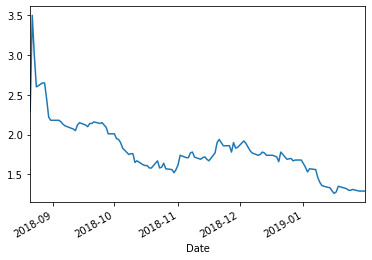

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
vol = xio['High']
vol.plot()

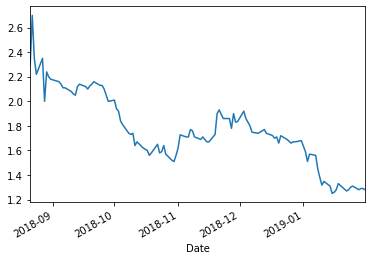

In [6]:
close = xio['Close']
close.plot()

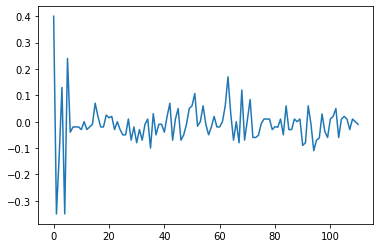

In [7]:
import numpy as np
returns = np.diff(close)
plt.plot(returns)

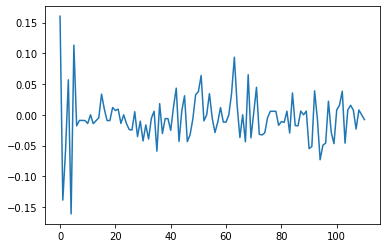

In [8]:
import numpy as np
returns = np.diff(np.log(close))
plt.plot(returns)

In [9]:
vol.corr(close)

0.9521701789295677

"0.95" shows a little less but still high correlation for the closing values for XIAOMI

# Time Series EDA

For a process to be stationary it should have: i] Constant Mean ii] Constant Variance iii] Unconditional joint probability distribution does not change when shifted in time iv] No seasonality

Now performing exponential smoothening on the 'Close' price for the stock

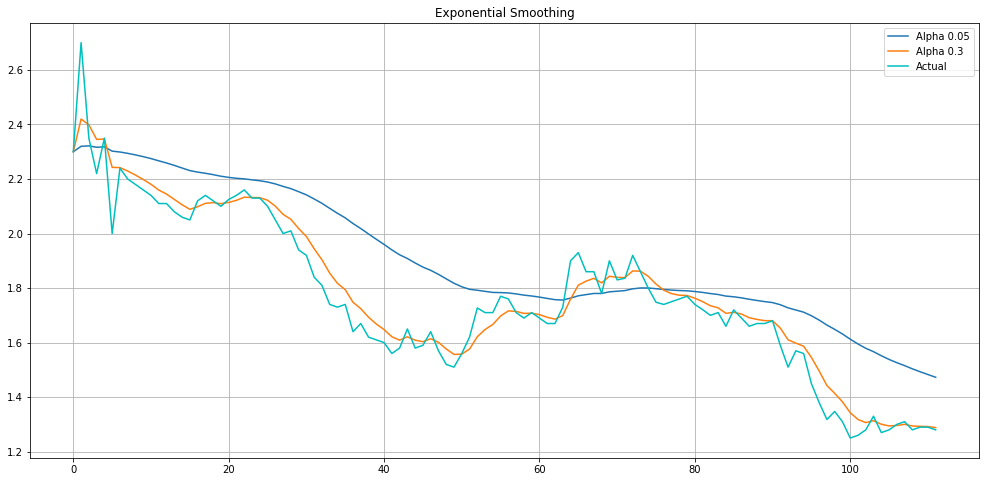

In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(xio.Close, [0.05, 0.3])

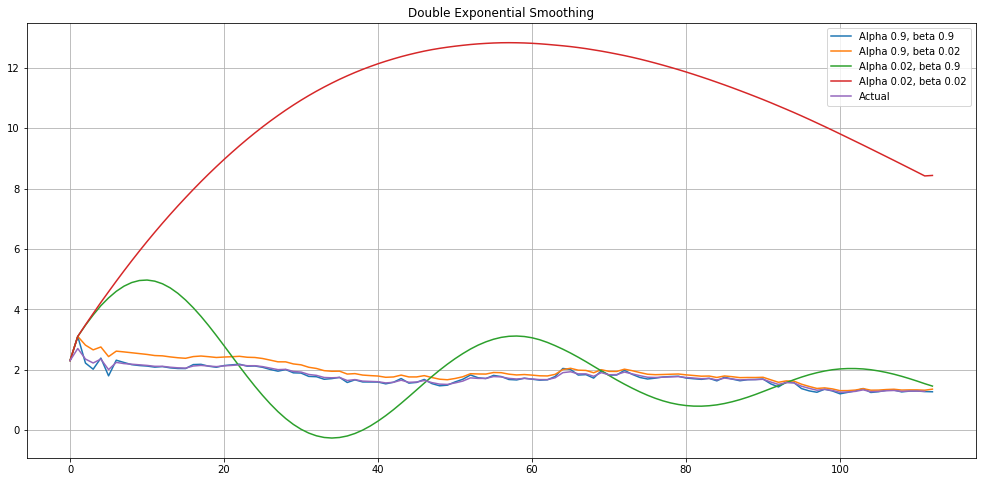

In [11]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(xio.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Observing the plotting for single and double exponential smoothening, we can conclude that Tesla's closing stock is non-stationary. Implying, there are trends and patterns that can be extracted. 
Now, we'll check the stationarity using Dicky-Fuller Test.

DICKY-FULLER TEST :

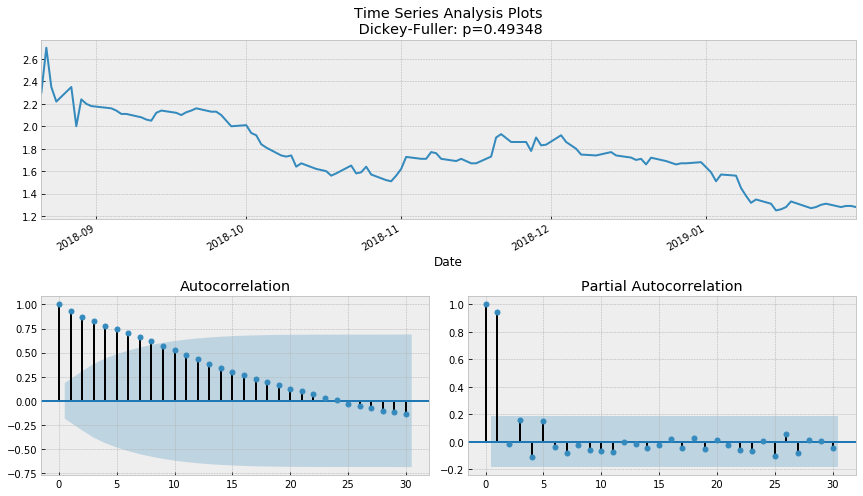

In [12]:
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(xio.Close, lags=30)

By the Dickey-Fuller test, the time series is non-stationary.

Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.

Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference: We simply subtract the time series from itself with a lag of one day, and we get:

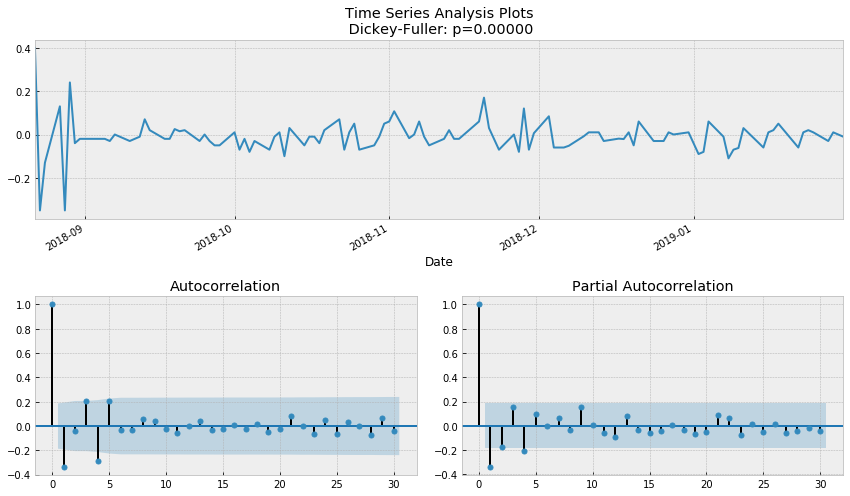

In [13]:
# Taking the first difference to remove to make the process stationary
data_diff = xio.Close - xio.Close.shift(1)

tsplot(data_diff[1:], lags=30)

Now, the closing price has been made stationary for modelling.

In [14]:
xio.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-08-21,2.30,2.30,2.30,2.30,8784200,2.30
2018-08-22,3.50,2.27,2.30,2.70,116872,2.70
2018-08-23,3.00,2.20,2.68,2.35,7406506,2.35
2018-08-24,2.60,2.22,2.60,2.22,4898137,2.22
2018-08-27,2.65,2.23,2.30,2.35,105011,2.35


Now, we'll be making a custom dataframe that contains the values to be used for the stock prediction

In [15]:
dfreg = xio.loc[:,['Adj Close', 'Volume']]
dfreg['HighLow_PCT'] = (xio['High'] - xio['Low']) / xio['Close'] * 100.0
dfreg['PCT_change'] = (xio['Close'] - xio['Open']) / xio['Open'] * 100.0
dfreg

,Adj Close,Volume,HighLow_PCT,PCT_change
Date,,,,
2018-08-21,2.30,8784200,0.000000,0.000000
2018-08-22,2.70,116872,45.555555,17.391309
2018-08-23,2.35,7406506,34.042553,-12.313439
2018-08-24,2.22,4898137,17.117111,-14.615380
2018-08-27,2.35,105011,17.872344,2.173911
...,...,...,...,...
2019-01-25,1.31,233220,1.145037,1.158300
2019-01-28,1.28,286706,2.343748,0.787401
2019-01-29,1.29,228935,1.550386,0.000000


We will be using 'Adj Close' values of our stock and predict it's values for our prediction

In [16]:
dfreg.fillna(value=-99999, inplace=True)

Using 15% of the data to forecast stocks for Tesla as per the data collected from 2011-2019

In [92]:
import math
forecast = int(math.ceil(0.06* len(dfreg)))
forecast

7

For prediction, we will be predicting 'Adjacent close' data for the stock

In [93]:
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast)
X = np.array(dfreg.drop(['label'], 1))
dfreg

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2018-08-21,2.30,8784200,0.000000,0.000000,2.20
2018-08-22,2.70,116872,45.555555,17.391309,2.18
2018-08-23,2.35,7406506,34.042553,-12.313439,2.16
2018-08-24,2.22,4898137,17.117111,-14.615380,2.14
2018-08-27,2.35,105011,17.872344,2.173911,2.11
...,...,...,...,...,...
2019-01-25,1.31,233220,1.145037,1.158300,NaN
2019-01-28,1.28,286706,2.343748,0.787401,NaN
2019-01-29,1.29,228935,1.550386,0.000000,NaN


In [95]:
dfreg.tail(8)

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2019-01-22,1.27,340109,3.937014,-1.550386,1.28
2019-01-23,1.28,273982,2.343748,-1.538460,NaN
2019-01-24,1.30,324862,0.769230,0.775193,NaN
2019-01-25,1.31,233220,1.145037,1.158300,NaN
2019-01-28,1.28,286706,2.343748,0.787401,NaN
2019-01-29,1.29,228935,1.550386,0.000000,NaN
2019-01-30,1.29,252088,1.550386,0.000000,NaN
2019-01-31,1.28,247216,3.124997,1.992030,NaN


The 'label' column of the dataframe is a copy of a shifted 'Adjusted Close' values. As the dataframe above shows, the column has been shifted to '2017-11-10' and hence the stock predictions will be done from that date. 

Scaling the 'X' for equal distribution during the linear regression

In [96]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [97]:
X_lately = X[-forecast:]
X = X[:-forecast]
X

array([[ 1.83014291e+00,  6.05089636e+00, -5.25634511e-01,
         3.13869394e-02],
       [ 3.19852930e+00, -2.31953483e-01,  6.76992290e+00,
         4.71602296e+00],
       [ 2.00119100e+00,  5.05222127e+00,  4.92615713e+00,
        -3.28544093e+00],
       [ 1.55646596e+00,  3.23393243e+00,  2.21560894e+00,
        -3.90550694e+00],
       [ 2.00119100e+00, -2.40551391e-01,  2.33655679e+00,
         6.16965744e-01],
       [ 8.03853522e-01, -1.84276816e-01,  4.67912368e+00,
        -6.57571666e+00],
       [ 1.62488519e+00, -1.74557505e-01,  1.11872580e+00,
        -2.27746916e+00],
       [ 1.48804672e+00, -2.26218887e-01, -1.60783367e-02,
        -2.11285350e-01],
       [ 1.41962748e+00, -2.93287058e-01, -8.48633336e-02,
         2.80800119e-01],
       [ 1.35120824e+00,  1.41204814e+00, -2.29067431e-01,
        -2.15738048e-01],
       [ 1.28278900e+00,  3.28803171e-01, -2.26293995e-01,
        -9.38996804e-02],
       [ 1.18015933e+00, -2.95368214e-01, -3.73835320e-01,
      

In [98]:
import numpy as np
y = np.array(dfreg['label'])
y
y = y[:-forecast]
y

array([2.20000005, 2.18000007, 2.16000009, 2.1400001 , 2.1099999 ,
       2.1099999 , 2.07999992, 2.05999994, 2.04990005, 2.11999989,
       2.1400001 , 2.11999989, 2.0999999 , 2.125     , 2.1400001 ,
       2.16000009, 2.13000011, 2.13000011, 2.0999999 , 2.04999995,
       2.        , 2.00999999, 1.94000006, 1.91999996, 1.84000003,
       1.80999994, 1.74000001, 1.73000002, 1.74000001, 1.63999999,
       1.66999996, 1.62      , 1.61000001, 1.60000002, 1.55999994,
       1.58000004, 1.64999998, 1.58000004, 1.59000003, 1.63999999,
       1.57000005, 1.51999998, 1.50999999, 1.55999994, 1.62      ,
       1.727     , 1.71000004, 1.71000004, 1.76999998, 1.75999999,
       1.71000004, 1.69000006, 1.71000004, 1.69000006, 1.66999996,
       1.66999996, 1.73000002, 1.89999998, 1.92999995, 1.86000001,
       1.86000001, 1.77999997, 1.89999998, 1.83000004, 1.83599997,
       1.91999996, 1.86000001, 1.79999995, 1.74800003, 1.74000001,
       1.75      , 1.75999999, 1.76999998, 1.74000001, 1.72099

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
rf_model = RandomForestRegressor()

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [101]:
rf_model.fit(X_train, y_train)

C:\Users\rachc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [102]:
rf_model.score(X_test, y_test)

0.7406647720279242

We have predicted values for the stock to 74% accuracy. Going further backwards makes the accuracy fall below 70%. Hence, the ideal date to start our prediction for the stock is from 2019-01-22. Only 9 days from the last date that has been picked for the stock.

In [104]:
type(y_test)

numpy.ndarray

In [105]:
forecast_set = rf_model.predict(X_lately)
print(forecast_set)

[1.44574997 1.60899998 1.60899998 1.36974998 1.59199998 1.59199998
 1.28299997]


My inference on this is that the stock has been on a serious decline and because the stock data for xiaomi is not available for a longer period of time, the date till which we can go back to predict stock's adjusted close date is incredibly low compared to the rest